In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

Chessboards
- given are 13 chessboards of diffrent dimensions:
- (7, 11), (7, 11), (5, 7), (5, 7), (5, 7), (5, 7), (5, 7), (5, 7), (5, 15), (5, 7),(5, 7),(5, 7),(5, 7)
- The checkerboard pattern used in the calibration sequence has squares with a size of approximately 10cm.


In [2]:
# functions to mask images and detect chessboard corners 
def detectChessBoard(img, pattern, xRegion, yRegion, applyFilter):
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    roi = (xRegion[0], yRegion[0], xRegion[1]-xRegion[0], yRegion[1]-yRegion[0])
    cv2.rectangle(mask, roi, 255, -1)
    masked_img = cv2.bitwise_and(img, img, mask=mask)
    cv2.imshow('img',masked_img)
    cv2.waitKey()
    if applyFilter:
        blurred = cv2.GaussianBlur(masked_img, (0, 0), 3)
        masked_img = cv2.addWeighted(masked_img, applyFilter[0], blurred, applyFilter[1], 0)

    ret, corners= cv2.findChessboardCorners(masked_img, pattern, None)
    if ret:
        corners = cv2.cornerSubPix(masked_img, corners, (11,11), (-1,-1), (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
        img = cv2.drawChessboardCorners(masked_img, pattern, corners, True)
        cv2.imshow('img',img)
        cv2.waitKey()

    return ret, corners
        

In [3]:
# LEFT 
checkerboards_left = [{'pattern': (7,11), 'count': 2, 'xValues': [(0,366),
    (356,476)], 'yValues': [(0, 600),
    (177,355)], 'applyFilters': [None, (1.5,-1.0)]},
            {'pattern': (5,7), 'count': 10,'xValues': [(466,640),
    (500,625),
    (476,674),
    (680,791),
    (786,910),
    (790,930),
    (1022,1210),
    (1090,1200),
    (980,1160), 
    (1330,1390)], 'yValues': [(60,150),
    (270,394),
    (395,500),
    (290,435),
    (290,435),
    (125,220),
    (60,150),
    (240,380),
    (380,470),
    (175,350)], 'applyFilters': [(1.5,-1.0), (1.5,-1.0), None, None, None, None, None, None, (1.5,-1.0), None]},    
            {'pattern': (5,15), 'count': 1,'xValues': [(1240,1315)], 'yValues': [(170,435)], 'applyFilters': [(1.5,-0.5)]}]    
###########################################################

In [4]:
# RIGHT
# gray_left = cv2.addWeighted(gray_left, 3.0, blurred, -0.6, 0)
checkerboards_right = [{'pattern': (7,11), 'count': 2, 'xValues': [(0,250),
    (300,400)], 'yValues': [(155, 340),
    (185,320)], 'applyFilters': [None, (3.0,-0.6)]},
            {'pattern': (5,7), 'count': 10,'xValues': [(377,540),
    (445,530),
    (415,570),
    (600,690),

    (710,810),
    (700,830),

    (900,1070),
    (1000,1100),
     
    (880,1030),
    (1210,1265)], 'yValues': [(85,160),
    (270,385),
    (385,475),
    (290,435),
    (290,435),
    (125,220),

    (60,140),
    (245,365),
    (360,450),
    (170,345)], 'applyFilters': [(1.5,-1.0), (1.5,-1.0), None, None, None, None, None, None, (1.5,-1.0), (1.5,-0.5)]},    
            {'pattern': (5,15), 'count': 1,'xValues': [(1135,1200)], 'yValues': [(160,425)], 'applyFilters': [(1.5,-0.5)]}]    
###########################################################


In [13]:
images_left = sorted(glob.glob('/home/hhauter/Documents/S23/Perception/34759-Perception-Exercises/2023_final_project/final_project/calib/image_02/data/*.png'))
images_right = sorted(glob.glob('/home/hhauter/Documents/S23/Perception/34759-Perception-Exercises/2023_final_project/final_project/calib/image_03/data/*.png'))
assert images_left
assert images_right

test_img = cv2.imread(images_left[0])
square_size = 10
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints_left = [] # 2d points in image plane.
imgpoints_right = [] # 2d points in image plane.
# create mask to make already detected chessboards invisible
mask = np.zeros((test_img.shape[0], test_img.shape[1]), dtype=np.uint8)

# read images
img_left = cv2.imread(images_left[0])
gray_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)

img_right = cv2.imread(images_right[0])
gray_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

cv2.imshow('img',img_right)
cv2.waitKey()

for cb_left, cb_right in zip(checkerboards_left, checkerboards_right):
    count = cb_left['count']
 
    for i in range(count):
        ret_left, corners_left = detectChessBoard(gray_left, cb_left['pattern'], cb_left['xValues'][i], cb_left['yValues'][i], cb_left['applyFilters'][i])
        ret_right, corners_right = detectChessBoard(gray_right, cb_right['pattern'], cb_right['xValues'][i], cb_right['yValues'][i], cb_right['applyFilters'][i])
        if ret_left and ret_right:
            # 10 mm apart 
            objp = np.zeros((cb_left['pattern'][0]*cb_left['pattern'][1],3), np.float32)
            objp[:,:2] = np.mgrid[0:cb_left['pattern'][1],0:cb_left['pattern'][0]].T.reshape(-1,2) * square_size
            objpoints.append(objp)
            imgpoints_left.append(corners_left)
            imgpoints_right.append(corners_right)
            
cv2.destroyAllWindows()



In [14]:
# get camera matrices
ret, K_left, dist_left, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints_left, gray_left.shape[::-1], None, None)
ret, K_right, dist_right, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints_right, gray_right.shape[::-1], None, None)

h,  w = img_left.shape[:2]
K_left, roi = cv2.getOptimalNewCameraMatrix(K_left,dist_left,(w,h),1,(w,h))
K_right, roi = cv2.getOptimalNewCameraMatrix(K_right,dist_right,(w,h),1,(w,h))
print(K_left)
print(K_right)
print(dist_left)
print(dist_right)

[[5.66661255e+02 0.00000000e+00 8.15384683e+02]
 [0.00000000e+00 1.50230103e+03 2.35944814e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[773.41186523   0.         749.32470836]
 [  0.         397.20623779 180.09680662]
 [  0.           0.           1.        ]]
[[-0.13895415 -0.05061588 -0.01294666  0.05368034  0.11693943]]
[[-0.01245151 -0.03565565 -0.16708289  0.04328778  0.24841336]]


Text(0.5, 1.0, 'Undistorted image')

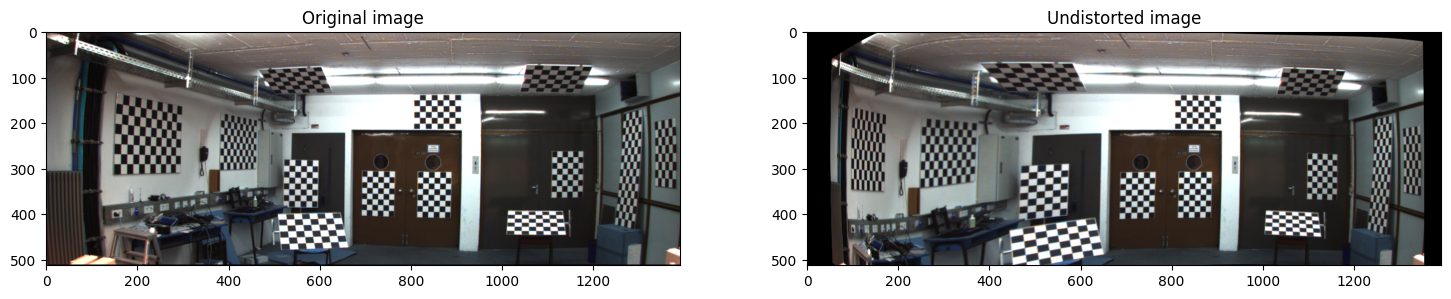

In [15]:
# undistord 
dst_left = cv2.undistort(img_left, K_left, dist_left, None, K_left)
dst_right = cv2.undistort(img_right, K_right, dist_left, None, K_left)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,18))
ax[0].imshow(img_left)
ax[0].set_title('Original image')
ax[1].imshow(dst_left)
ax[1].set_title('Undistorted image')

In [18]:
# rectification

ret, K1, D1, K2, D2, R, T, E, F = cv2.stereoCalibrate(objpoints, imgpoints_left, imgpoints_right, K_left, dist_left, K_right, dist_right, gray_left.shape[::-1], cv2.CALIB_FIX_INTRINSIC)

R1, R2, P1, P2, Q, roi_left, roi_right = cv2.stereoRectify(K_left, dist_left, K_right, dist_right, gray_left.shape[::-1], R, T, flags=cv2.CALIB_ZERO_DISPARITY, alpha=0)

map1_left, map2_left = cv2.initUndistortRectifyMap(K1, D1, R1, P1, gray_left.shape[::-1],  cv2.CV_32FC1)
map1_right, map2_right = cv2.initUndistortRectifyMap(K2, D2, R2, P2, gray_right.shape[::-1],  cv2.CV_32FC1)

left_rectified = cv2.remap(img_left, map1_left, map2_left, cv2.INTER_LINEAR)
right_recified = cv2.remap(img_right, map1_right, map2_right, cv2.INTER_LINEAR)


In [19]:

cv2.imshow('img',left_rectified)
cv2.waitKey()
cv2.destroyAllWindows()

In [8]:
cv2.destroyAllWindows()

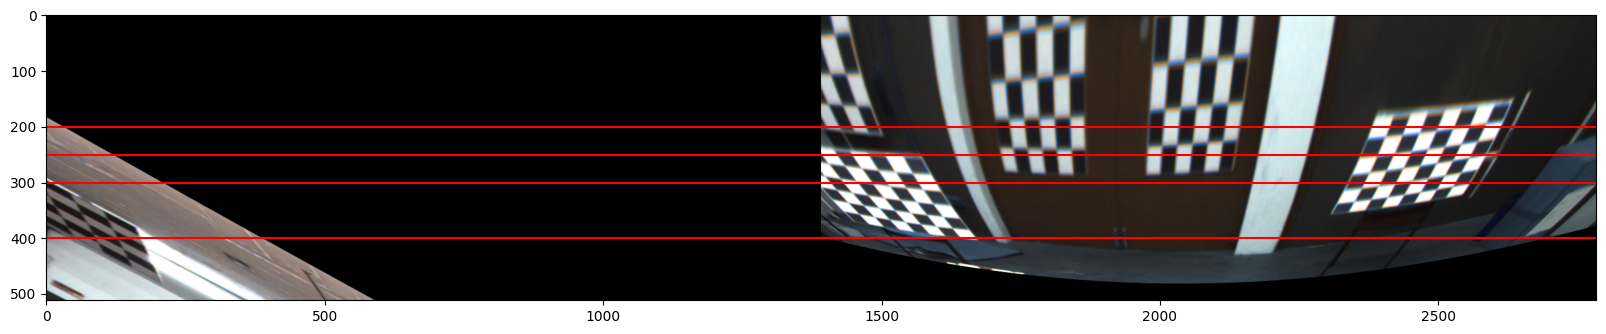

In [20]:
imgs_comb = np.hstack([left_rectified, right_recified])

plt.figure(figsize=(20,12))
plt.axhline(250, color='r') # horizontal
plt.axhline(200, color='r') # horizontal
plt.axhline(300, color='r') # horizontal
plt.axhline(400, color='r') # horizontal
plt.imshow(imgs_comb)
plt.show()